In [1]:
import torch, torch.utils.data
from torch import nn
import torchvision, torchvision.datasets
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List

import sys
sys.path.append('./fedlab/main/fedlab_benchmarks/leaf/')

sys.path.append('./fedlab/main/fedlab_benchmarks/')

sys.path.append('./fedlab/main/')

sys.path.append('./fedlab/')

from fedlab.main.fedlab_benchmarks.leaf.dataloader import get_LEAF_dataloader

from torch.profiler import profile, record_function, ProfilerActivity
import time
from sklearn.metrics import f1_score   
import numpy as np
    
import random

In [2]:
print(torch.__version__)




2.0.0


In [3]:

train_loaders = []
test_loaders = []
num_nodes = 5
num_class = 10
epoch_total = 15
pickle_name = "mnist-P2P-epoch-"+str(epoch_total)

In [4]:
device = torch.device('cuda')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [5]:

transform = transforms.Compose([
    transforms.ToTensor(),
])
target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x),num_class).float()

In [6]:
# def split_dataset(dataset, n):
#     torch.utils.data.random_split(dataset, )

In [7]:
# train_dataset2 = torchvision.datasets.MNIST('datasets/', download=True, train=True, transform=transform, target_transform=target_transform),
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000000, num_workers=0)

# test_dataset = torchvision.datasets.MNIST('datasets/', download=True, train=False, transform=transform, target_transform=target_transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000000, num_workers=0)


# Inital MNIST
train_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=True, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)
test_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=False, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)

train_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0, pin_memory=True) for i in train_datasets]
test_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0, pin_memory=True) for i in test_datasets]


In [8]:
print(len(train_loaders))
print(len(test_loaders))
print(test_loaders)
print(len(test_loaders[0].dataset))

5
5
[<torch.utils.data.dataloader.DataLoader object at 0x7f75b78cb5e0>, <torch.utils.data.dataloader.DataLoader object at 0x7f74b68f72e0>, <torch.utils.data.dataloader.DataLoader object at 0x7f74b68f4940>, <torch.utils.data.dataloader.DataLoader object at 0x7f74b68f7580>, <torch.utils.data.dataloader.DataLoader object at 0x7f74b68f6ad0>]
2000


In [9]:

x_i_j = {}
s_i = {}

ypred = []
ylabels = []

In [10]:
class FederatedNode:
    def __init__(self, train_dataloader, test_dataloader, node_id) -> None:
        self.dataset_size = len(train_dataloader.dataset)
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in train_dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0])
            channels_squared_sum += torch.mean(data**2, dim=[0])
            num_batches += 1
    
        self.mean = channels_sum / num_batches
        self.test_loss = 0.0
        self.test_accuracy = 0.0
        self.train_accuracy = 0.0
        self.train_loss = 0.0
        self.f1_score = 0.0


        # std = sqrt(E[X^2] - (E[X])^2)
        self.std = (channels_squared_sum / num_batches - self.mean ** 2) ** 0.5
        print("Dataset size ", self.dataset_size)
        print("Mean size ", self.mean.shape)
        print("Standard deviation size ", self.std.shape)
        
        
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,56),
            nn.ReLU(),
            nn.Linear(56, 10)
        ).to(device)

        '''
        only_digits=False
        self.network = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(9216, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10 if only_digits else 62),
        nn.ReLU()
        ).to(device)
        '''
        self.optimizer = torch.optim.Adam(self.network.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.node_id = node_id
    
    def train_epoch(self):
        losses = []
        correct = 0
        total = 0
        train_accuracy = []
        for idx, (data_x, data_y) in enumerate(self.train_dataloader):
            #print("data_x", data_x.shape)
            #print("data_y", data_y.shape)
            #plt.imshow(data_x[1][0])
            output = self.network(data_x.to(device))
            self.optimizer.zero_grad()
            #print(output.shape)
            #print(data_y)
            #data_y = target_transform(data_y)
            
            #loss = nn.functional.mse_loss(output, data_y.to(device))
            loss = self.criterion(output, data_y.to(device))
            losses.append(loss.item())
            loss.backward()
            self.optimizer.step()

            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            train_accuracy.append(correct / total)
            ypred.append(data_y)
            ylabels.append(true_labels)
        self.train_accuracy = train_accuracy[-1]
        self.train_loss = sum(losses)/len(losses)
        return self.train_accuracy, self.train_loss
    
    def testing(self):
        correct = 0
        total = 0
        # test_running_loss = 0.0
        predictions = []
        labels = []
        test_accuracy = []
        test_running_losses = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            output = self.network(data_x.to(device))
            
            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            
            loss = self.criterion(output, data_y)
            predictions.append(predicted.cpu())
            #labels.append(data_y.cpu())
            labels.append(true_labels.cpu())
            test_running_losses.append(loss.item())
            #print('Epoch %d test loss: %.3f' % (idx + 1, test_running_losses[-1]))
            #print(test_running_losses)
            #test_running_loss += loss.item()
            #test_loss.append(test_running_loss / len(self.test_dataloader))
            test_accuracy.append(correct / total)
        
        #print(predictions)
        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        self.f1_score= f1_score(labels, predictions, average="weighted")
        self.test_accuracy = test_accuracy[-1]
        #print(self.test_accuracy)
        self.test_loss =  sum(test_running_losses)/len(test_running_losses)
        #print("test loss ",self.test_loss)
       
    
    def share_x_ij(self):
        x = self.network.state_dict()
        r = torch.randint(1, 5, [num_nodes])
        s_r = torch.sum(r)
        j=self.node_id
        for i in range(num_nodes):
            x_i_j[(i,j)]={}
            for key in x.keys():
                x_i_j[(i,j)][key]=x[key]*r[i]/s_r
                
        
    
    def share_s_i(self):
        i = self.node_id
        s_i[i] = {}
        for key in x_i_j[(0,0)].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in range(num_nodes)])

    def share_x_ij_neighbours(self, neighbour_nodes):
        j=self.node_id
        num_neighbour_nodes = len(neighbour_nodes)
        x = self.network.state_dict()
        r = torch.randint(1, 5, [num_neighbour_nodes])
        s_r = torch.sum(r)
        
        for i, n in enumerate(neighbour_nodes):
            x_i_j[(n,j)]={}
            for key in x.keys():
                x_i_j[(n,j)][key]=x[key]*r[i]/s_r

    def share_s_i_neighbours(self, neighbour_nodes):
        i = self.node_id
        s_i[i] = {}
        
        for key in x_i_j[list(x_i_j.keys())[0]].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in neighbour_nodes])


    def share_FedavgP2P(self, nodes):
        dataset_size_all = [n.dataset_size for n in nodes]
        i = self.node_id
        C = 0.5
        A = num_nodes - 1
        m = C*A
        #n_k = self.dataset_size

        # Random clients
        S_t = random.sample([ j for j in range(num_nodes) if j!=i], int(m)) 
        S_t.append(self.node_id)
        #print("Clients ",S_t)
        #S_t = random.sample(list(range(num_nodes)) , int(m))
        #print("n_k ",n_k)
        #print("m neighbors", m)
        #print("S_t", S_t)
        w_c = self.network.state_dict()
        n_c = self.dataset_size
        n_t = n_c
        for s in S_t:
            n_t += dataset_size_all[s]
                
        for key in nodes[0].network.state_dict():

            for j in S_t: 
                n_k = dataset_size_all[j]
                #states = nodes[j].network.state_dict()
                averaged_state = {}
            
                for key in self.network.state_dict().keys():
                    param_value = 0
                    for i in S_t:
                        param_value += nodes[i].network.state_dict()[key]
                    
                    averaged_state[key] = param_value/len(S_t)
                #print(averaged_state)
                contributed_state = averaged_state[key]
                w_c[key] = contributed_state
                
        self.network.load_state_dict(w_c)

In [11]:
#for i, loader_data in enumerate(zip(*loader)):
#    train_loaders, test_loaders = loader_data

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 

#nodes = [FederatedNode(l, i) for i,l in enumerate())]

Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [12]:
losses = {}
train_accuracies = {}
test_accuracies = {}
test_losses = {}
f1_scores = {}
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("model_training"):

start_time = time.time()
dataset_size_all = {}
epochs ={i:0 for i in range(num_nodes)}

for i in tqdm(range(epoch_total*num_nodes)):
    cands = [i for i in epochs if epochs[i]<epoch_total]
    node = nodes[cands[torch.randint(len(cands), (1,)).item()]]
    del cands
    train_acc, loss = node.train_epoch()
    node.share_FedavgP2P(nodes)


        
    
    epochs[node.node_id] += 1
    losses[(node.node_id, epochs[node.node_id])]=loss
    train_accuracies[(node.node_id, epochs[node.node_id])]=train_acc
    print(f"node={node.node_id}, epoch={epochs[node.node_id]}, acc={train_acc}")
    # for i, node in enumerate(nodes):
        #print()
        #print("Node ", i)
        
    node.testing()
    #test_losses.append(node.test_loss)
    #print("Node Test Accuracy", node.test_accuracy)
    #print("Node Test loss", node.test_loss)
    #print("Node F1_Score ", node.f1_score)
    test_accuracies[(node.node_id, epochs[node.node_id])]=node.test_accuracy
    test_losses[(node.node_id, epochs[node.node_id])]=node.test_loss
    f1_scores[(node.node_id, epochs[node.node_id])]=node.f1_score
        



    
    
    
    # states = [i.network.state_dict() for i in nodes]
    # av_state = {}
    # for key in states[0]:
    #     av_state[key] = sum([s[key] for s in states])/num_nodes
    # for node in nodes:
    #     node.network.load_state_dict(av_state)

time_FL_SMPC = time.time() - start_time

print("Time taken by FL with SMPC", time_FL_SMPC)
    


  0%|          | 0/75 [00:00<?, ?it/s]

node=4, epoch=1, acc=0.09066666666666667


  1%|▏         | 1/75 [00:02<03:22,  2.74s/it]

node=4, epoch=2, acc=0.15433333333333332


  3%|▎         | 2/75 [00:04<02:45,  2.27s/it]

node=4, epoch=3, acc=0.30041666666666667


  4%|▍         | 3/75 [00:06<02:38,  2.21s/it]

node=3, epoch=1, acc=0.10133333333333333


  5%|▌         | 4/75 [00:08<02:27,  2.08s/it]

node=1, epoch=1, acc=0.053


  7%|▋         | 5/75 [00:10<02:26,  2.09s/it]

node=0, epoch=1, acc=0.09025


  8%|▊         | 6/75 [00:12<02:22,  2.07s/it]

node=2, epoch=1, acc=0.09983333333333333


  9%|▉         | 7/75 [00:14<02:15,  1.99s/it]

node=2, epoch=2, acc=0.25066666666666665


 11%|█         | 8/75 [00:16<02:12,  1.99s/it]

node=4, epoch=4, acc=0.4093333333333333


 12%|█▏        | 9/75 [00:18<02:07,  1.93s/it]

node=3, epoch=2, acc=0.18075


 13%|█▎        | 10/75 [00:20<02:03,  1.91s/it]

node=2, epoch=3, acc=0.345


 15%|█▍        | 11/75 [00:22<02:02,  1.91s/it]

node=0, epoch=2, acc=0.2185


 16%|█▌        | 12/75 [00:24<01:59,  1.90s/it]

node=1, epoch=2, acc=0.21616666666666667


 17%|█▋        | 13/75 [00:26<01:58,  1.92s/it]

node=1, epoch=3, acc=0.3445


 19%|█▊        | 14/75 [00:28<01:58,  1.94s/it]

node=0, epoch=3, acc=0.31833333333333336


 20%|██        | 15/75 [00:29<01:53,  1.90s/it]

node=1, epoch=4, acc=0.40508333333333335


 21%|██▏       | 16/75 [00:31<01:50,  1.87s/it]

node=3, epoch=3, acc=0.2718333333333333


 23%|██▎       | 17/75 [00:33<01:49,  1.89s/it]

node=1, epoch=5, acc=0.4509166666666667


 24%|██▍       | 18/75 [00:35<01:46,  1.87s/it]

node=2, epoch=4, acc=0.42475


 25%|██▌       | 19/75 [00:39<02:16,  2.43s/it]

node=0, epoch=4, acc=0.3709166666666667


 27%|██▋       | 20/75 [00:42<02:27,  2.68s/it]

node=3, epoch=4, acc=0.36533333333333334


 28%|██▊       | 21/75 [00:45<02:24,  2.67s/it]

node=3, epoch=5, acc=0.4439166666666667


 29%|██▉       | 22/75 [00:47<02:14,  2.54s/it]

node=1, epoch=6, acc=0.4974166666666667


 31%|███       | 23/75 [00:49<02:09,  2.48s/it]

node=3, epoch=6, acc=0.49666666666666665


 32%|███▏      | 24/75 [00:51<02:02,  2.41s/it]

node=1, epoch=7, acc=0.53775


 33%|███▎      | 25/75 [00:54<01:59,  2.40s/it]

node=2, epoch=5, acc=0.49675


 35%|███▍      | 26/75 [00:56<01:54,  2.34s/it]

node=0, epoch=5, acc=0.41608333333333336


 36%|███▌      | 27/75 [00:58<01:52,  2.34s/it]

node=4, epoch=5, acc=0.5345833333333333


 37%|███▋      | 28/75 [01:01<01:48,  2.31s/it]

node=3, epoch=7, acc=0.5309166666666667


 39%|███▊      | 29/75 [01:03<01:47,  2.34s/it]

node=0, epoch=6, acc=0.45916666666666667


 40%|████      | 30/75 [01:05<01:43,  2.30s/it]

node=1, epoch=8, acc=0.5623333333333334


 41%|████▏     | 31/75 [01:08<01:42,  2.32s/it]

node=0, epoch=7, acc=0.5026666666666667


 43%|████▎     | 32/75 [01:10<01:39,  2.32s/it]

node=3, epoch=8, acc=0.56025


 44%|████▍     | 33/75 [01:12<01:38,  2.34s/it]

node=2, epoch=6, acc=0.5535


 45%|████▌     | 34/75 [01:15<01:35,  2.33s/it]

node=0, epoch=8, acc=0.5420833333333334


 47%|████▋     | 35/75 [01:17<01:34,  2.36s/it]

node=3, epoch=9, acc=0.5821666666666667


 48%|████▊     | 36/75 [01:19<01:32,  2.36s/it]

node=1, epoch=9, acc=0.5868333333333333


 49%|████▉     | 37/75 [01:22<01:30,  2.38s/it]

node=3, epoch=10, acc=0.6038333333333333


 51%|█████     | 38/75 [01:24<01:27,  2.36s/it]

node=0, epoch=9, acc=0.584


 52%|█████▏    | 39/75 [01:26<01:24,  2.34s/it]

node=3, epoch=11, acc=0.6250833333333333


 53%|█████▎    | 40/75 [01:29<01:22,  2.36s/it]

node=3, epoch=12, acc=0.6465


 55%|█████▍    | 41/75 [01:31<01:19,  2.34s/it]

node=1, epoch=10, acc=0.6125833333333334


 56%|█████▌    | 42/75 [01:33<01:17,  2.35s/it]

node=3, epoch=13, acc=0.67175


 57%|█████▋    | 43/75 [01:36<01:14,  2.31s/it]

node=4, epoch=6, acc=0.5843333333333334


 59%|█████▊    | 44/75 [01:38<01:13,  2.38s/it]

node=1, epoch=11, acc=0.6375


 60%|██████    | 45/75 [01:40<01:09,  2.32s/it]

node=2, epoch=7, acc=0.59325


 61%|██████▏   | 46/75 [01:43<01:07,  2.32s/it]

node=1, epoch=12, acc=0.6599166666666667


 63%|██████▎   | 47/75 [01:45<01:03,  2.28s/it]

node=4, epoch=7, acc=0.6238333333333334


 64%|██████▍   | 48/75 [01:47<01:02,  2.30s/it]

node=0, epoch=10, acc=0.6245833333333334


 65%|██████▌   | 49/75 [01:49<00:58,  2.27s/it]

node=2, epoch=8, acc=0.6201666666666666


 67%|██████▋   | 50/75 [01:52<00:56,  2.27s/it]

node=1, epoch=13, acc=0.67725


 68%|██████▊   | 51/75 [01:54<00:53,  2.25s/it]

node=2, epoch=9, acc=0.63875


 69%|██████▉   | 52/75 [01:57<00:54,  2.36s/it]

node=3, epoch=14, acc=0.69375


 71%|███████   | 53/75 [01:59<00:51,  2.36s/it]

node=0, epoch=11, acc=0.659


 72%|███████▏  | 54/75 [02:01<00:49,  2.36s/it]

node=1, epoch=14, acc=0.69425


 73%|███████▎  | 55/75 [02:03<00:46,  2.31s/it]

node=0, epoch=12, acc=0.6881666666666667


 75%|███████▍  | 56/75 [02:06<00:43,  2.31s/it]

node=2, epoch=10, acc=0.6519166666666667


 76%|███████▌  | 57/75 [02:08<00:41,  2.29s/it]

node=4, epoch=8, acc=0.6533333333333333


 77%|███████▋  | 58/75 [02:10<00:39,  2.30s/it]

node=3, epoch=15, acc=0.7131666666666666


 79%|███████▊  | 59/75 [02:13<00:36,  2.29s/it]

node=2, epoch=11, acc=0.6603333333333333


 80%|████████  | 60/75 [02:15<00:34,  2.33s/it]

node=1, epoch=15, acc=0.7093333333333334


 81%|████████▏ | 61/75 [02:17<00:32,  2.33s/it]

node=4, epoch=9, acc=0.6724166666666667


 83%|████████▎ | 62/75 [02:20<00:30,  2.32s/it]

node=4, epoch=10, acc=0.6884166666666667


 84%|████████▍ | 63/75 [02:22<00:27,  2.28s/it]

node=2, epoch=12, acc=0.6683333333333333


 85%|████████▌ | 64/75 [02:24<00:25,  2.31s/it]

node=4, epoch=11, acc=0.6980833333333333


 87%|████████▋ | 65/75 [02:26<00:23,  2.30s/it]

node=4, epoch=12, acc=0.7040833333333333


 88%|████████▊ | 66/75 [02:29<00:20,  2.33s/it]

node=4, epoch=13, acc=0.7109166666666666


 89%|████████▉ | 67/75 [02:31<00:18,  2.32s/it]

node=2, epoch=13, acc=0.6773333333333333


 91%|█████████ | 68/75 [02:33<00:16,  2.32s/it]

node=4, epoch=14, acc=0.71925


 92%|█████████▏| 69/75 [02:36<00:13,  2.28s/it]

node=2, epoch=14, acc=0.6860833333333334


 93%|█████████▎| 70/75 [02:38<00:11,  2.28s/it]

node=0, epoch=13, acc=0.7113333333333334


 95%|█████████▍| 71/75 [02:40<00:09,  2.27s/it]

node=2, epoch=15, acc=0.6938333333333333


 96%|█████████▌| 72/75 [02:43<00:06,  2.30s/it]

node=0, epoch=14, acc=0.7298333333333333


 97%|█████████▋| 73/75 [02:45<00:04,  2.28s/it]

node=4, epoch=15, acc=0.7263333333333334


 99%|█████████▊| 74/75 [02:47<00:02,  2.32s/it]

node=0, epoch=15, acc=0.741


100%|██████████| 75/75 [02:49<00:00,  2.27s/it]

Time taken by FL with SMPC 169.9557888507843


In [13]:
losses2 = [[losses[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
train_accuracies2 = [[train_accuracies[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
test_accuracies2 = [[test_accuracies[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
test_losses2 = [[test_losses[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
f1_scores2 = [[f1_scores[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]

In [14]:
import pickle

try:
    my_pickle_results = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result = {}
    result2 = {}
    myResults = my_pickle_results
except (OSError, IOError) as e:
    my_pickle_results = {}
    result = {}
    result2 = {}

In [15]:
result["train_accuracies"] = train_accuracies2
result["train_losses"] = losses2
result["test_accuracies"] = test_accuracies2
result["test_losses"] = test_losses2
result["f1_scores"] = f1_scores2
result["ypred"] = ypred
result["ylabels"] = ylabels
result["time_taken"] = time_FL_SMPC

my_pickle_results["floppy"] = result

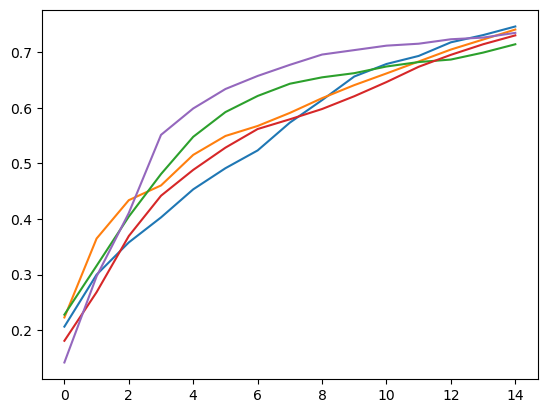

In [16]:
plt.plot(test_accuracies2)

In [17]:
print(losses2)

[[2.312532424926758, 2.3106510639190674, 2.304226875305176, 2.303882360458374, 2.3070223331451416], [2.266028881072998, 2.268716335296631, 2.2603917121887207, 2.2615489959716797, 2.261082887649536], [2.2233352661132812, 2.2316551208496094, 2.220193386077881, 2.2169840335845947, 2.2166435718536377], [2.18068790435791, 2.193993091583252, 2.178745985031128, 2.1702473163604736, 2.172386646270752], [2.1370317935943604, 2.1543426513671875, 2.1343908309936523, 2.1223223209381104, 2.1261537075042725], [2.091583490371704, 2.112476110458374, 2.0879104137420654, 2.073497772216797, 2.07970929145813], [2.0444374084472656, 2.0686392784118652, 2.039964437484741, 2.024021863937378, 2.0321474075317383], [1.9960263967514038, 2.0231425762176514, 1.9911972284317017, 1.9740078449249268, 1.9836465120315552], [1.9469671249389648, 1.9763741493225098, 1.941805124282837, 1.9236923456192017, 1.9342272281646729], [1.8976199626922607, 1.9288004636764526, 1.8920528888702393, 1.873207688331604, 1.8839037418365479], 

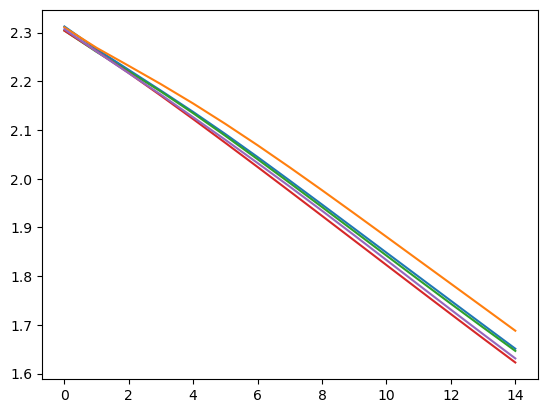

In [18]:
plt.plot(losses2)

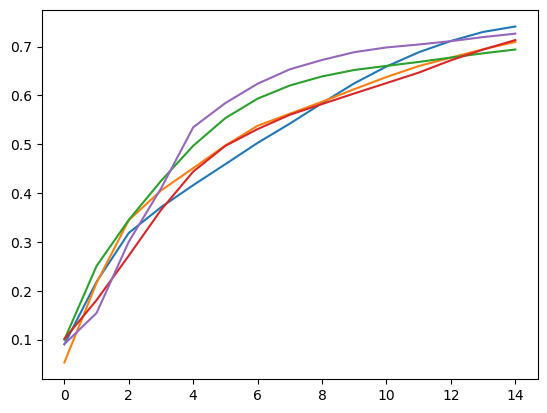

In [19]:
plt.plot(train_accuracies2)

In [20]:

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 


Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [21]:
with open(pickle_name+'.pickle', 'wb') as handle:
    pickle.dump(my_pickle_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
labels = []
for _, label in train_loaders[0]:
    labels.append(label)
#print(labels)
#print(classification_report(y_true, y_pred, target_names=target_names))

In [23]:
#Testing pickle

import pickle

try:
    my_pickle_results3 = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result3 = {}
    result4 = {}
    myResults = my_pickle_results3
except (OSError, IOError) as e:
    my_pickle_results = {}
    resul3 = {}
    result4 = {}

print(my_pickle_results3["floppy"]["train_losses"])

[[2.312532424926758, 2.3106510639190674, 2.304226875305176, 2.303882360458374, 2.3070223331451416], [2.266028881072998, 2.268716335296631, 2.2603917121887207, 2.2615489959716797, 2.261082887649536], [2.2233352661132812, 2.2316551208496094, 2.220193386077881, 2.2169840335845947, 2.2166435718536377], [2.18068790435791, 2.193993091583252, 2.178745985031128, 2.1702473163604736, 2.172386646270752], [2.1370317935943604, 2.1543426513671875, 2.1343908309936523, 2.1223223209381104, 2.1261537075042725], [2.091583490371704, 2.112476110458374, 2.0879104137420654, 2.073497772216797, 2.07970929145813], [2.0444374084472656, 2.0686392784118652, 2.039964437484741, 2.024021863937378, 2.0321474075317383], [1.9960263967514038, 2.0231425762176514, 1.9911972284317017, 1.9740078449249268, 1.9836465120315552], [1.9469671249389648, 1.9763741493225098, 1.941805124282837, 1.9236923456192017, 1.9342272281646729], [1.8976199626922607, 1.9288004636764526, 1.8920528888702393, 1.873207688331604, 1.8839037418365479], 

In [24]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-05-13 20:59:08
